In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
from sklearn import preprocessing
import os
from statistics import mean
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
directory = "../../data_files/"
path = directory + 'vibrationdata/'
prod_quality_log = pd.read_csv(directory + 'product_quality_log.csv')
target_names = list(dict.fromkeys(prod_quality_log['quality']))

### Feature engineering on time series data using Signal Processing. 
For each data point:
1. Two signals Sensor1 and Sensor2 are added and Windowing is done on the resulting signal using Hanning Window.
2. The windowed signal is transformed using Fast Fourier Transformation.
3. Two largest amplitude peaks of the resulting transformation are used as features for machine learning modelling.

In [3]:
# Signal components (frequency,time)
sample_frequency = 20480 # Hz
signal_timewindow = 1 # seconds
    
t = np.linspace(0, signal_timewindow, round(signal_timewindow*sample_frequency))

In [4]:
def generate_signal(path):
    df = pd.read_csv(path, sep='\t', names = ['Sensor 1', 'Sensor 2'])
    signal = np.sin(df['Sensor 1'] + df['Sensor 2'])
    signal = np.asarray(signal)
    return signal

In [5]:
def show_signal_plot(time, signal, window_signal):
    # Plot Signal
    plt.ylabel("Signal")
    plt.xlabel("Time [s]")
    plt.title("Plot of Signal Data")
    plt.plot(time, signal)
    plt.show()
    # Plot Windowed Data
    plt.ylabel("Windowed Signal")
    plt.xlabel("Time [s]")
    plt.title("Plot of Windowed Signal (Hanning Window)")
    plt.plot(time, window_signal)
    plt.show()

In [6]:
def amplitude_peaks(path):
    amp1 = []
    amp2 = []

    for file in os.listdir(path):
        # Generate Signal Data
        x = generate_signal(path+file)

        num_samples = x.size
        num_half = num_samples//2
        f = np.fft.fftfreq(t.shape[-1])*sample_frequency # frequency information
        # Apply Hanning Window
        window = np.hamming(num_samples)
        x_window = x*window

        # Compute Fast Fourier Transform
        fft_window = np.fft.fft(x_window)       # complex spectrum
        fft_window_abs = np.abs(fft_window)     # amplitude spectrum

        # Get amplitude peaks
        peaks_index, properties = find_peaks(fft_window_abs[:num_half] / num_samples, height=0.001)

        amp_list = properties['peak_heights'].tolist()
        freq_list = peaks_index.tolist()

        largest_amp = max(amp_list)
        index1 = amp_list.index(largest_amp)
        largest_freq =  freq_list[index1]

        amp_list.remove(largest_amp)
        freq_list.remove(largest_freq)

        second_largest_amp = max(amp_list)
        index2 = amp_list.index(second_largest_amp)
        second_largest_freq =  freq_list[index2]

        amp1.append(largest_amp)
        amp2.append(second_largest_amp)
        
    #Plot of a signal 
    show_signal_plot(t,x,x_window)
        
    return {'amplitude1': amp1, 'amplitude2': amp2}

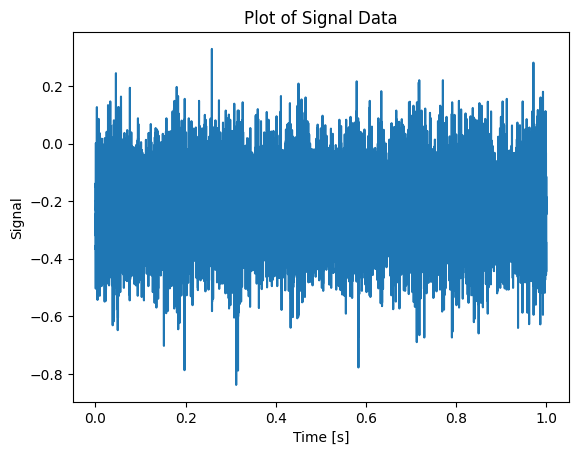

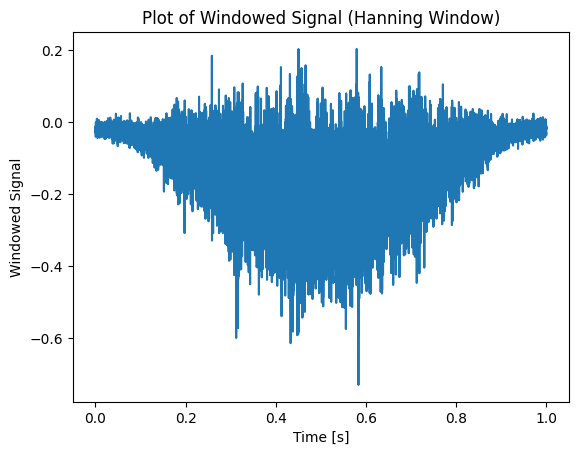

In [7]:
# Feature extraction - get amplitude peak values using FFT
features = amplitude_peaks(path)

### Dataset Preparation

In [8]:
lb = preprocessing.LabelBinarizer()
target = lb.fit_transform(prod_quality_log['quality'])

In [9]:
(X,y) = (pd.DataFrame(features),target)

In [10]:
X.head()

,amplitude1,amplitude2
0,0.027509,0.004046
1,0.024566,0.006919
2,0.026344,0.007211
3,0.025832,0.004590
4,0.026259,0.007966


In [11]:
y

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

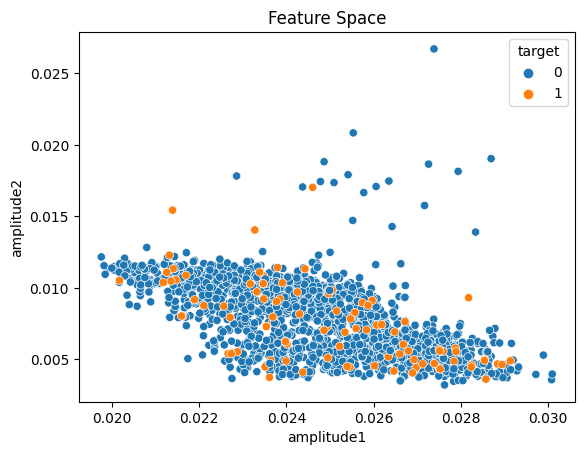

In [12]:
features["target"] = pd.Series(y.flatten())
#Plot of Feature Space
sns.scatterplot(data=features, x="amplitude1", y="amplitude2", hue = "target")
plt.title('Feature Space')
plt.show()

### Classification

In [13]:
def cross_validation(X,y):
    #Build model
    model = RandomForestClassifier(n_estimators=100, random_state=0)
    #Create Stratified K-fold cross validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    scoring = ('f1', 'recall', 'precision')
    #evaluate model
    scores = cross_validate(model, X, y, scoring=scoring, cv=cv)
    #Get average evaluation metrics
    print('Mean f1: %.3f' % mean(scores['test_f1']))
    print('Mean recall: %.3f' % mean(scores['test_recall']))
    print('Mean precision: %.3f' % mean(scores['test_precision']))

    scores_acc = cross_val_score(model, X,y, cv=cv, scoring='accuracy')
    print("Average accuracy: {}".format(np.mean(scores_acc)))
    return model

In [14]:
def conf_matrix(y_test,y_test_pred):
    cm = confusion_matrix(y_test, y_test_pred)
    ConfusionMatrixDisplay(cm, display_labels=target_names).plot()
    print(classification_report(y_test, y_test_pred, target_names=target_names))

In [15]:
# Count of datapoints for each class
classes, counts = np.unique(y, return_counts=True)
dict(zip(classes, counts))

{0: 1564, 1: 92}

The dataset prepared in the feature engineering step contains unbalanced data. Stratified K-Fold Cross Validation is used to preserve class distribution in samples.

#### Modelling with unbalanced dataset

In [16]:
# Stratified K-fold cross validation results
rf_model = cross_validation(X,y)

Mean f1: 0.012
Mean recall: 0.007
Mean precision: 0.050
Average accuracy: 0.9400971157356699


              precision    recall  f1-score   support

          OK       0.95      0.99      0.97       517
         nOK       0.25      0.03      0.06        30

    accuracy                           0.94       547
   macro avg       0.60      0.51      0.51       547
weighted avg       0.91      0.94      0.92       547



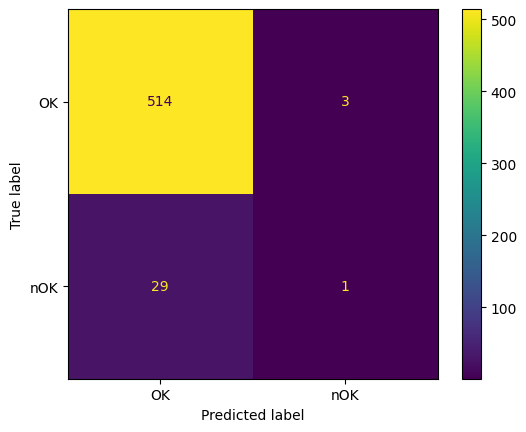

In [17]:
#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
# Train model
rf_model.fit(X_train, y_train)
#Prediction
y_test_pred = rf_model.predict(X_test)
#Create confusion matrix
conf_matrix(y_test,y_test_pred)

#### Modelling with balanced dataset

Data imbalance is handled using SMOTE, by oversampling the minority class.

In [18]:
oversample = SMOTE()
resampled_X, resampled_y = oversample.fit_resample(X, y)

In [19]:
# Count of datapoints for each class
classes, counts = np.unique(resampled_y, return_counts=True)
dict(zip(classes, counts))

{0: 1564, 1: 1564}

In [20]:
# Stratified K-fold cross validation results
rf_smote_model = cross_validation(resampled_X,resampled_y)

Mean f1: 0.796
Mean recall: 0.826
Mean precision: 0.770
Average accuracy: 0.7888193249774719


              precision    recall  f1-score   support

          OK       1.00      0.91      0.95       517
         nOK       0.40      0.97      0.56        30

    accuracy                           0.92       547
   macro avg       0.70      0.94      0.76       547
weighted avg       0.96      0.92      0.93       547



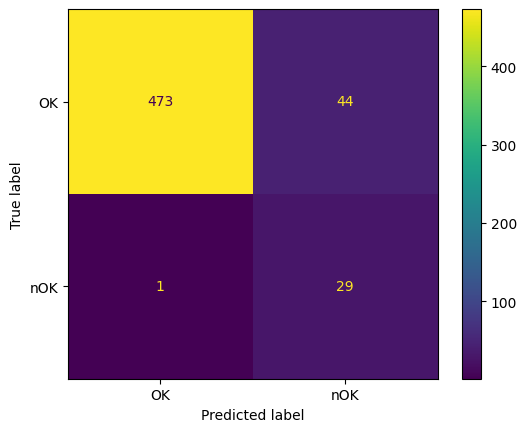

In [21]:
resampled_X_train, resampled_X_test, resampled_y_train, resampled_y_test= train_test_split(
    resampled_X, resampled_y, test_size=0.33, stratify=resampled_y)
#Train model
rf_smote_model.fit(resampled_X_train, resampled_y_train)
#Prediction
y_test_pred = rf_smote_model.predict(X_test)
#Create confusion matrix
conf_matrix(y_test,y_test_pred)

#### Performance evaluation after handling data imbalance

| Indicator| Explanation |
| :-: | :- |
| precision | Improved for OK and slightly for nOK class |
| recall | Achieved significant improvement in classification of nOK class, but at the cost of a slight decrease for the OK class|
| f1-score | Improved for the nOK class and remains almost same for OK class|